In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Advanced optimizers (SGD vs Momentum vs Adam)

In [2]:
# Create a simple dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_simple_model():
    """Create a simple neural network model"""
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(20,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Function to train model with different optimizers
def train_with_optimizer(optimizer_name, optimizer):
    """Train model with a specific optimizer and return training history"""
    model = create_simple_model()
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    print(f"\nTraining with {optimizer_name}...")
    history = model.fit(X_train, y_train,
                       epochs=50,
                       validation_data=(X_test, y_test),
                       verbose=0)  # Silent training

    final_accuracy = history.history['val_accuracy'][-1]
    print(f"{optimizer_name} Final Validation Accuracy: {final_accuracy:.4f}")

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training with Basic SGD...
Basic SGD Final Validation Accuracy: 0.8500

Training with SGD with Momentum...
SGD with Momentum Final Validation Accuracy: 0.8100

Training with Adam...
Adam Final Validation Accuracy: 0.8600


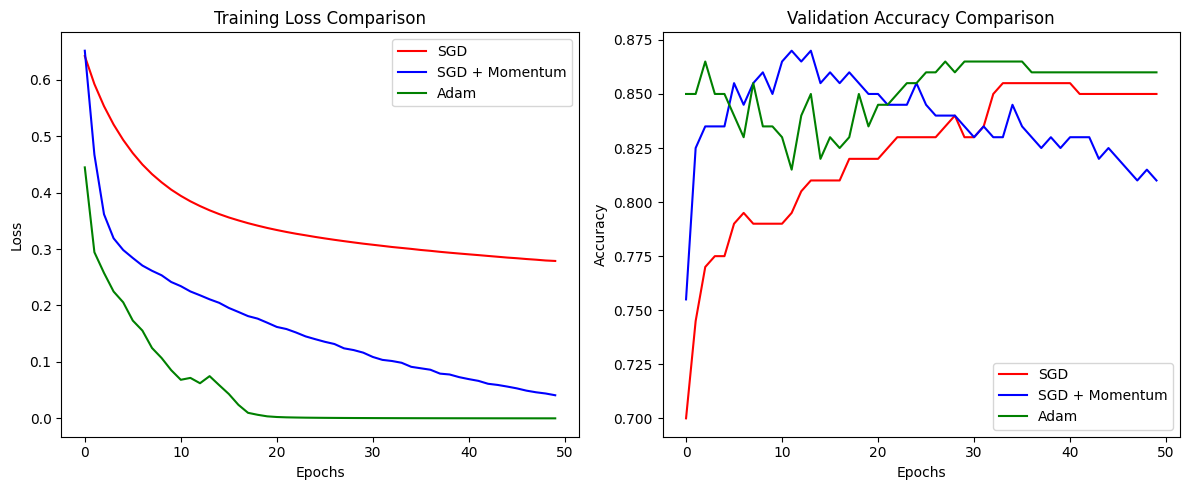


Key Insights about Optimizers:
• SGD: Simple but can be slow and get stuck in local minima
• Momentum: Helps SGD move faster and more smoothly
• Adam: Usually converges faster and is more stable


In [3]:
# 1.1 Basic SGD (Stochastic Gradient Descent)
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.01)
sgd_history = train_with_optimizer("Basic SGD", sgd_optimizer)

# 1.2 SGD with Momentum
momentum_optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
momentum_history = train_with_optimizer("SGD with Momentum", momentum_optimizer)

# 1.3 Adam Optimizer
adam_optimizer = keras.optimizers.Adam(learning_rate=0.01)
adam_history = train_with_optimizer("Adam", adam_optimizer)

# Plot comparison of optimizers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sgd_history.history['loss'], label='SGD', color='red')
plt.plot(momentum_history.history['loss'], label='SGD + Momentum', color='blue')
plt.plot(adam_history.history['loss'], label='Adam', color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_history.history['val_accuracy'], label='SGD', color='red')
plt.plot(momentum_history.history['val_accuracy'], label='SGD + Momentum', color='blue')
plt.plot(adam_history.history['val_accuracy'], label='Adam', color='green')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### learning rate scheduling


Training with Fixed LR (0.1)...
Fixed LR (0.1):
  Final Validation Accuracy: 0.5350
  Final Validation Loss: 0.6911

Training with Step Decay (Piecewise)...
  Epoch 15: LR reduced from 0.100000 to 0.050000
  Epoch 30: LR reduced from 0.050000 to 0.025000
  Epoch 45: LR reduced from 0.025000 to 0.012500
Step Decay (Piecewise):
  Final Validation Accuracy: 0.8550
  Final Validation Loss: 2.0280

Training with Exponential Decay...
Exponential Decay:
  Final Validation Accuracy: 0.8500
  Final Validation Loss: 1.8895

Training with Power Decay...
Power Decay:
  Final Validation Accuracy: 0.8300
  Final Validation Loss: 1.9781

Training with Piecewise Decay...
Piecewise Decay:
  Final Validation Accuracy: 0.8200
  Final Validation Loss: 2.0034

Training with Performance-Based...

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.01250

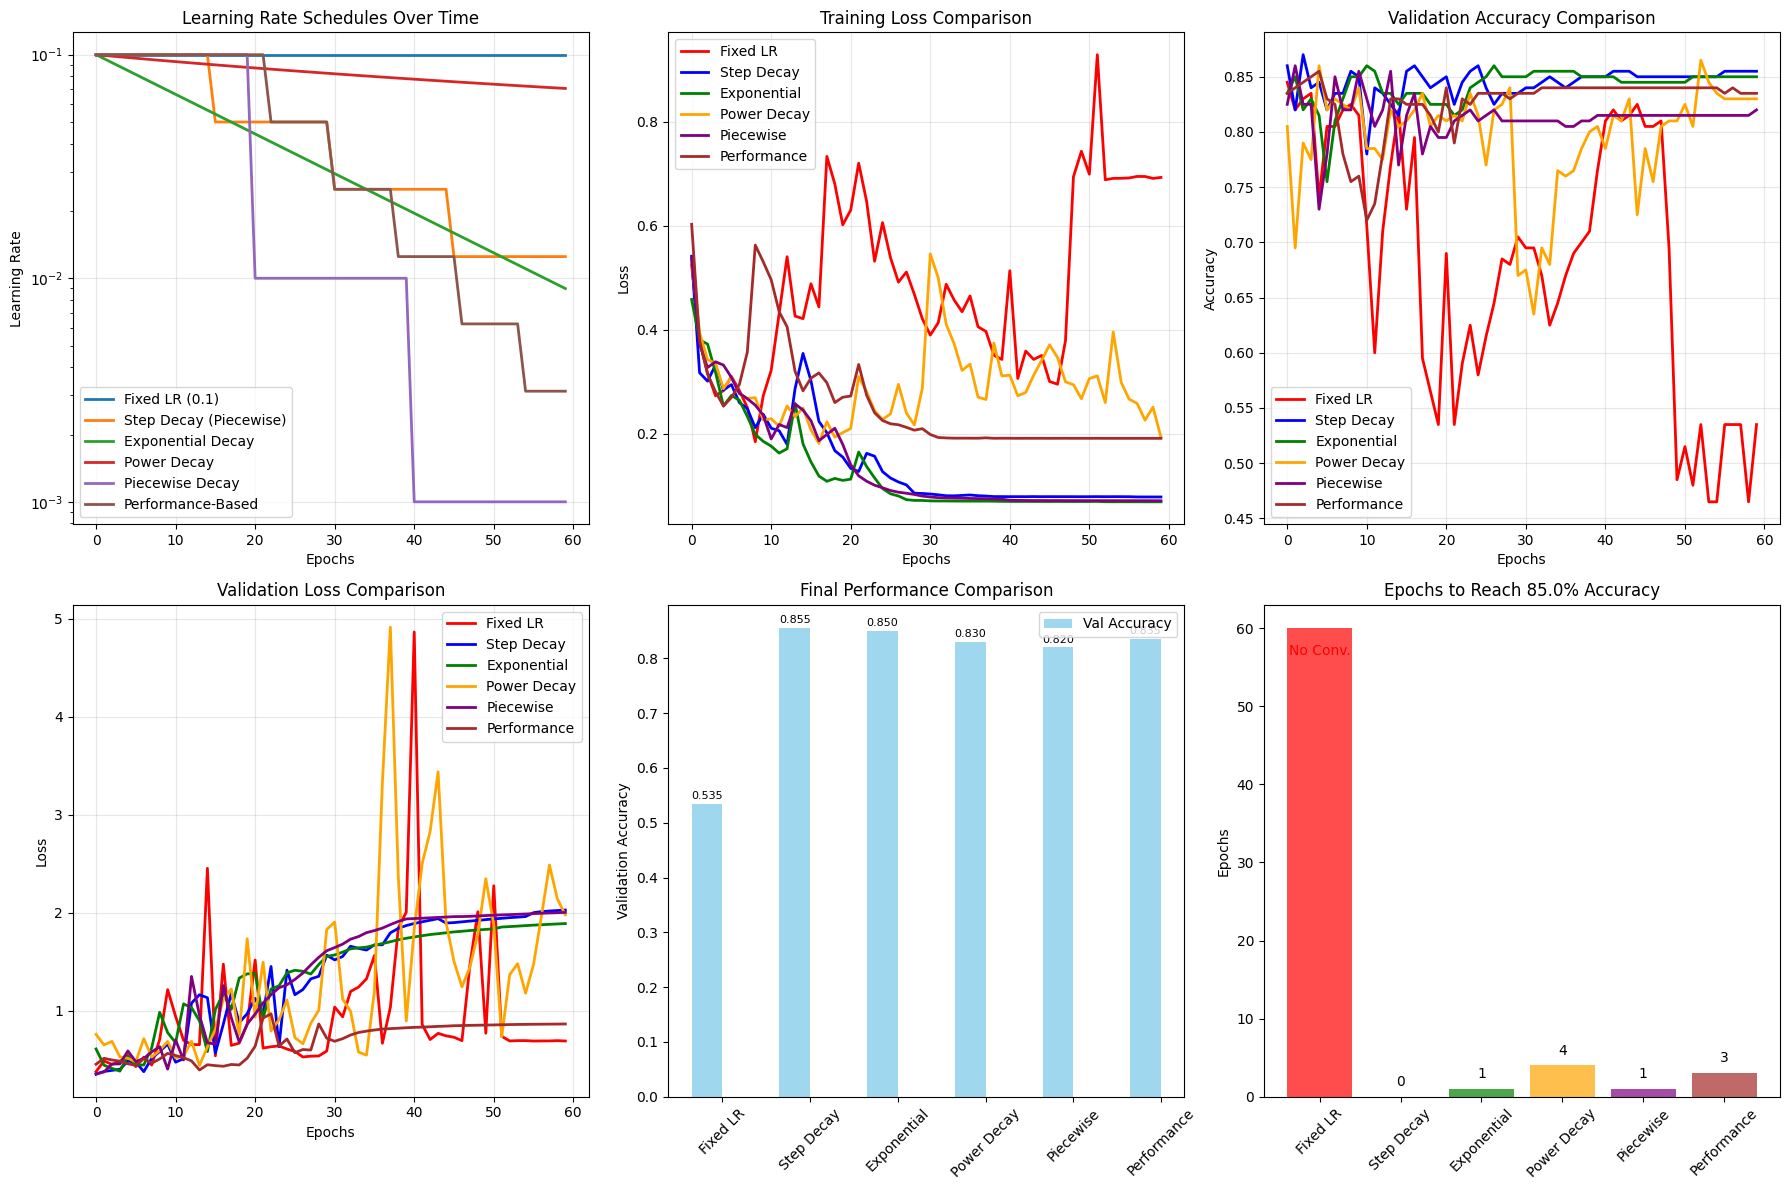


LEARNING RATE SCHEDULING PERFORMANCE SUMMARY
Schedule Type        Final Val Acc   Final Val Loss  Epochs to 85%  
--------------------------------------------------------------------------------
Fixed LR             0.5350          0.6911          Not reached    
Step Decay           0.8550          2.0280          0              
Exponential          0.8500          1.8895          1              
Power Decay          0.8300          1.9781          4              
Piecewise            0.8200          2.0034          1              
Performance          0.8350          0.8649          3              


In [4]:
# Store learning rates for visualization
lr_histories = {}

def train_with_lr_schedule(schedule_name, scheduler, track_lr=True):
    """Train model with learning rate scheduling and track LR changes"""
    model = create_simple_model()

    # Custom callback to track learning rate changes
    class LRTracker(keras.callbacks.Callback):
        def __init__(self):
            self.lrs = []

        def on_epoch_begin(self, epoch, logs=None):
            lr = float(self.model.optimizer.learning_rate)
            self.lrs.append(lr)

    lr_tracker = LRTracker()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),  # Start with high LR
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    print(f"\nTraining with {schedule_name}...")

    # Add callbacks
    callbacks = []
    if scheduler:
        callbacks.append(scheduler)
    if track_lr:
        callbacks.append(lr_tracker)

    history = model.fit(X_train, y_train,
                       epochs=60,  # More epochs to see scheduling effects
                       validation_data=(X_test, y_test),
                       callbacks=callbacks,
                       verbose=0)

    # Store learning rate history
    if track_lr:
        lr_histories[schedule_name] = lr_tracker.lrs

    final_accuracy = history.history['val_accuracy'][-1]
    final_loss = history.history['val_loss'][-1]
    print(f"{schedule_name}:")
    print(f"  Final Validation Accuracy: {final_accuracy:.4f}")
    print(f"  Final Validation Loss: {final_loss:.4f}")

    return history

# 2.1 No Learning Rate Scheduling (Fixed LR)
no_schedule_history = train_with_lr_schedule("Fixed LR (0.1)", None)

# 2.3 Exponential Decay
def exponential_decay_scheduler(epoch, lr):
    initial_lr = 0.1
    decay_rate = 0.96  # 4% reduction each epoch
    new_lr = initial_lr * (decay_rate ** epoch)
    return new_lr

exp_callback = keras.callbacks.LearningRateScheduler(exponential_decay_scheduler)
exp_history = train_with_lr_schedule("Exponential Decay", exp_callback)

# 2.4 Power Decay (Polynomial Decay) - Gradual polynomial reduction
def power_decay_scheduler(epoch, lr):
    initial_lr = 0.1
    decay_rate = 0.01
    power = 0.75
    new_lr = initial_lr * ((1 + decay_rate * epoch) ** (-power))
    return new_lr

power_callback = keras.callbacks.LearningRateScheduler(power_decay_scheduler)
power_history = train_with_lr_schedule("Power Decay", power_callback)

# 2.5 Piecewise Decay
def piecewise_decay_scheduler(epoch, lr):
    initial_lr = 0.1

    if epoch < 20:
        return initial_lr
    elif epoch < 40:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

piecewise_callback = keras.callbacks.LearningRateScheduler(piecewise_decay_scheduler)
piecewise_history = train_with_lr_schedule("Piecewise Decay", piecewise_callback)

# 2.6 Performance-Based Scheduling
performance_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # Reduce LR by half
    patience=8,           # Wait 8 epochs before reducing
    min_lr=0.0001,       # Don't go below this LR
    verbose=1
)

performance_history = train_with_lr_schedule("Performance-Based", performance_callback)

# Create comprehensive comparison plots
plt.figure(figsize=(18, 12))

# Plot 1: Learning Rate Schedules Over Time
plt.subplot(2, 3, 1)
epochs = range(len(lr_histories['Fixed LR (0.1)']))
for schedule_name, lrs in lr_histories.items():
    plt.plot(epochs[:len(lrs)], lrs, label=schedule_name, linewidth=2)

plt.title('Learning Rate Schedules Over Time')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Log scale to see all schedules clearly
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training Loss Comparison
plt.subplot(2, 3, 2)
schedules_and_histories = [
    ('Fixed LR', no_schedule_history, 'red'),
    ('Exponential', exp_history, 'green'),
    ('Power Decay', power_history, 'orange'),
    ('Piecewise', piecewise_history, 'purple'),
    ('Performance', performance_history, 'brown')
]

for name, history, color in schedules_and_histories:
    plt.plot(history.history['loss'], label=name, color=color, linewidth=2)

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy Comparison
plt.subplot(2, 3, 3)
for name, history, color in schedules_and_histories:
    plt.plot(history.history['val_accuracy'], label=name, color=color, linewidth=2)

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Validation Loss Comparison
plt.subplot(2, 3, 4)
for name, history, color in schedules_and_histories:
    plt.plot(history.history['val_loss'], label=name, color=color, linewidth=2)

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Final Performance Comparison (Bar Chart)
plt.subplot(2, 3, 5)
schedule_names = [name for name, _, _ in schedules_and_histories]
final_accuracies = [history.history['val_accuracy'][-1] for _, history, _ in schedules_and_histories]
final_losses = [history.history['val_loss'][-1] for _, history, _ in schedules_and_histories]

x = np.arange(len(schedule_names))
width = 0.35

bars1 = plt.bar(x - width/2, final_accuracies, width, label='Val Accuracy', alpha=0.8, color='skyblue')
plt.ylabel('Validation Accuracy')
plt.title('Final Performance Comparison')
plt.xticks(x, schedule_names, rotation=45)
plt.legend()

# Add value labels on bars
for bar, acc in zip(bars1, final_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 6: Training Speed Analysis (Convergence Rate)
plt.subplot(2, 3, 6)
target_accuracy = 0.85  # Target accuracy threshold

convergence_epochs = []
for name, history, color in schedules_and_histories:
    val_acc = history.history['val_accuracy']
    converged_epoch = next((i for i, acc in enumerate(val_acc) if acc >= target_accuracy), len(val_acc))
    convergence_epochs.append(converged_epoch)

plt.bar(schedule_names, convergence_epochs, color=['red', 'blue', 'green', 'orange', 'purple', 'brown'], alpha=0.7)
plt.title(f'Epochs to Reach {target_accuracy:.1%} Accuracy')
plt.ylabel('Epochs')
plt.xticks(rotation=45)

# Add value labels
for i, epochs in enumerate(convergence_epochs):
    if epochs < len(val_acc):
        plt.text(i, epochs + 1, str(epochs), ha='center', va='bottom')
    else:
        plt.text(i, epochs - 2, 'No Conv.', ha='center', va='top', color='red')

plt.tight_layout()
plt.show()

# Performance Summary Table
print("\n" + "=" * 80)
print("LEARNING RATE SCHEDULING PERFORMANCE SUMMARY")
print("=" * 80)
print(f"{'Schedule Type':<20} {'Final Val Acc':<15} {'Final Val Loss':<15} {'Epochs to 85%':<15}")
print("-" * 80)

for i, (name, history, _) in enumerate(schedules_and_histories):
    final_acc = history.history['val_accuracy'][-1]
    final_loss = history.history['val_loss'][-1]
    conv_epochs = convergence_epochs[i]
    conv_str = str(conv_epochs) if conv_epochs < len(history.history['val_accuracy']) else "Not reached"

    print(f"{name:<20} {final_acc:<15.4f} {final_loss:<15.4f} {conv_str:<15}")

#### Regularization technique such as dropout and early technique

In [5]:
def create_model_with_dropout(dropout_rate=0.0):
    """Create model with optional dropout layers"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(20,)),
        layers.Dropout(dropout_rate),  # Randomly set some neurons to 0
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_with_regularization(model_name, model, use_early_stopping=False):
    """Train model with regularization techniques"""
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    print(f"\nTraining {model_name}...")

    callbacks = []
    if use_early_stopping:
        # Stop training if validation loss doesn't improve for 10 epochs
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        callbacks.append(early_stop)

    history = model.fit(X_train, y_train,
                       epochs=100,  # More epochs to see overfitting
                       validation_data=(X_test, y_test),
                       callbacks=callbacks,
                       verbose=0)

    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    print(f"{model_name}:")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Overfitting Gap: {final_train_acc - final_val_acc:.4f}")

    return history


Training No Regularization...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


No Regularization:
  Final Training Accuracy: 1.0000
  Final Validation Accuracy: 0.8600
  Overfitting Gap: 0.1400

Training With Dropout (30%)...
With Dropout (30%):
  Final Training Accuracy: 0.9862
  Final Validation Accuracy: 0.8300
  Overfitting Gap: 0.1562

Training Dropout + Early Stopping...
Dropout + Early Stopping:
  Final Training Accuracy: 0.8988
  Final Validation Accuracy: 0.8350
  Overfitting Gap: 0.0638


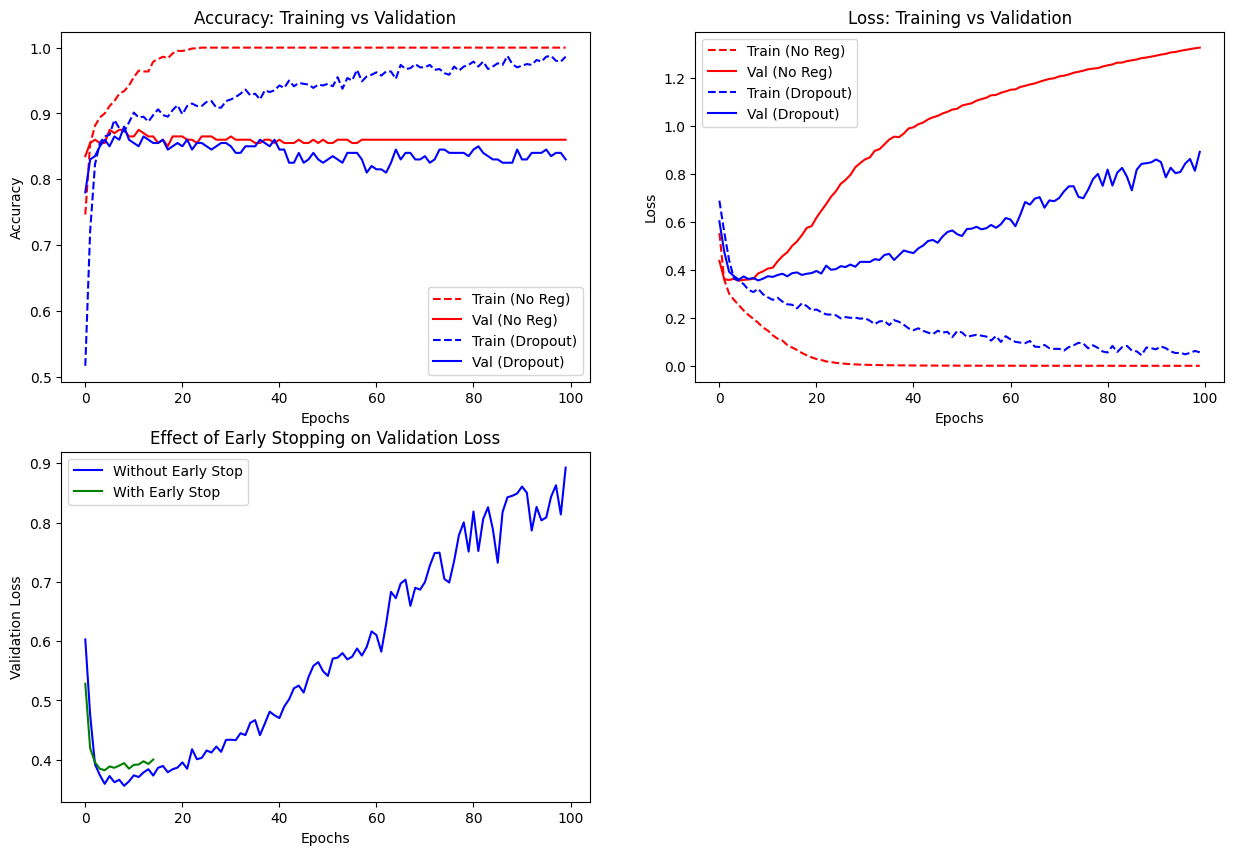

In [6]:
# 3.1 No Regularization (Prone to overfitting)
no_reg_model = create_model_with_dropout(dropout_rate=0.0)
no_reg_history = train_with_regularization("No Regularization", no_reg_model)

# 3.2 With Dropout (Prevents overfitting)
dropout_model = create_model_with_dropout(dropout_rate=0.3)  # 30% dropout
dropout_history = train_with_regularization("With Dropout (30%)", dropout_model)

# 3.3 With Dropout + Early Stopping
dropout_early_model = create_model_with_dropout(dropout_rate=0.3)
dropout_early_history = train_with_regularization(
    "Dropout + Early Stopping",
    dropout_early_model,
    use_early_stopping=True
)

# Plot regularization comparison
plt.figure(figsize=(15, 10))

# Training vs Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(no_reg_history.history['accuracy'], label='Train (No Reg)', color='red', linestyle='--')
plt.plot(no_reg_history.history['val_accuracy'], label='Val (No Reg)', color='red')
plt.plot(dropout_history.history['accuracy'], label='Train (Dropout)', color='blue', linestyle='--')
plt.plot(dropout_history.history['val_accuracy'], label='Val (Dropout)', color='blue')
plt.title('Accuracy: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training vs Validation Loss
plt.subplot(2, 2, 2)
plt.plot(no_reg_history.history['loss'], label='Train (No Reg)', color='red', linestyle='--')
plt.plot(no_reg_history.history['val_loss'], label='Val (No Reg)', color='red')
plt.plot(dropout_history.history['loss'], label='Train (Dropout)', color='blue', linestyle='--')
plt.plot(dropout_history.history['val_loss'], label='Val (Dropout)', color='blue')
plt.title('Loss: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Early Stopping Effect
plt.subplot(2, 2, 3)
plt.plot(dropout_history.history['val_loss'], label='Without Early Stop', color='blue')
plt.plot(dropout_early_history.history['val_loss'], label='With Early Stop', color='green')
plt.title('Effect of Early Stopping on Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

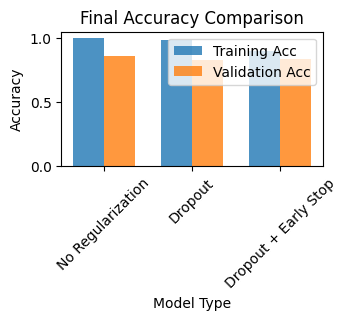


Key Insights about Regularization:
• Dropout: Randomly ignores some neurons during training
  - Forces network to not rely on specific neurons
  - Reduces overfitting and improves generalization
• Early Stopping: Stops training when validation performance stops improving
  - Prevents overfitting to training data
  - Saves training time and computational resources
• Gap between training and validation accuracy indicates overfitting


In [7]:
# Final comparison
plt.subplot(2, 2, 4)
models = ['No Regularization', 'Dropout', 'Dropout + Early Stop']
train_accs = [
    no_reg_history.history['accuracy'][-1],
    dropout_history.history['accuracy'][-1],
    dropout_early_history.history['accuracy'][-1]
]
val_accs = [
    no_reg_history.history['val_accuracy'][-1],
    dropout_history.history['val_accuracy'][-1],
    dropout_early_history.history['val_accuracy'][-1]
]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Training Acc', alpha=0.8)
plt.bar(x + width/2, val_accs, width, label='Validation Acc', alpha=0.8)
plt.title('Final Accuracy Comparison')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.xticks(x, models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
